In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data 
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

/home/ge/anaconda3/envs/lizards/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


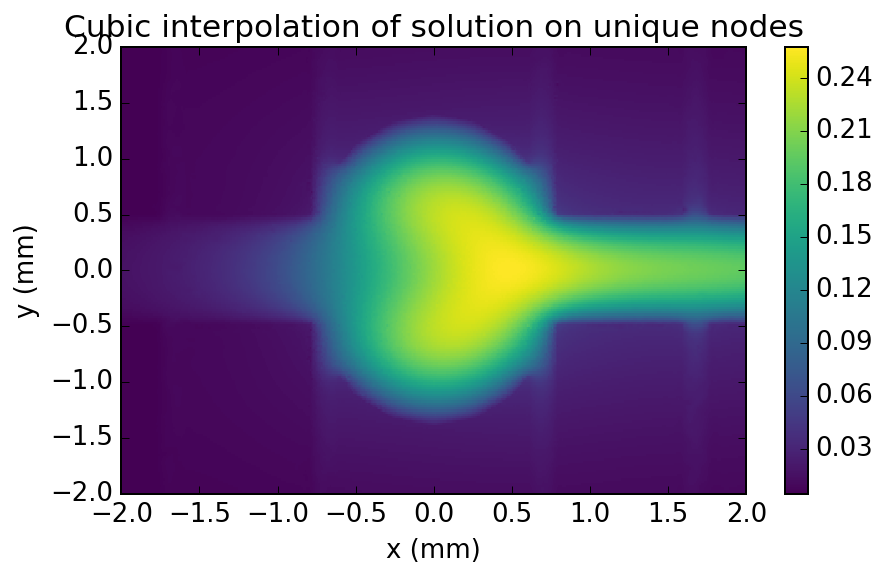

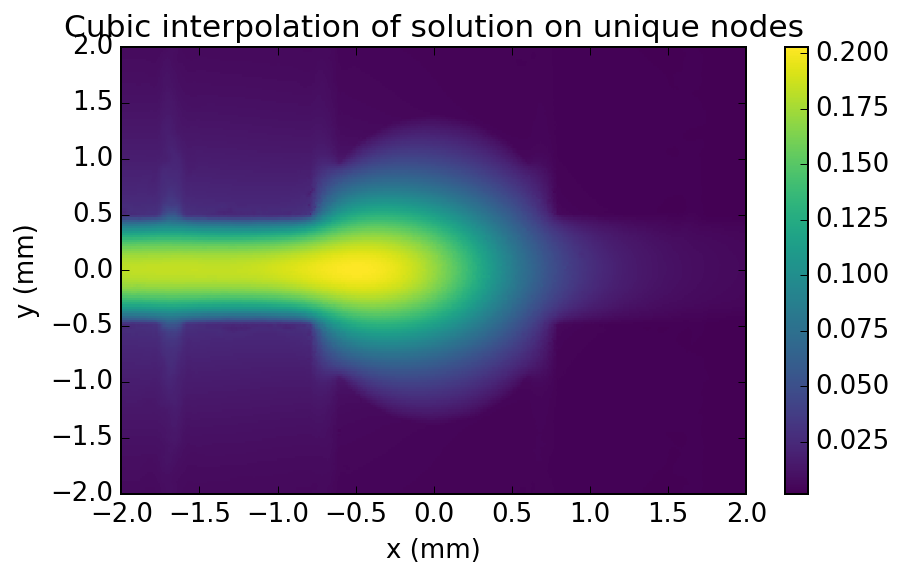

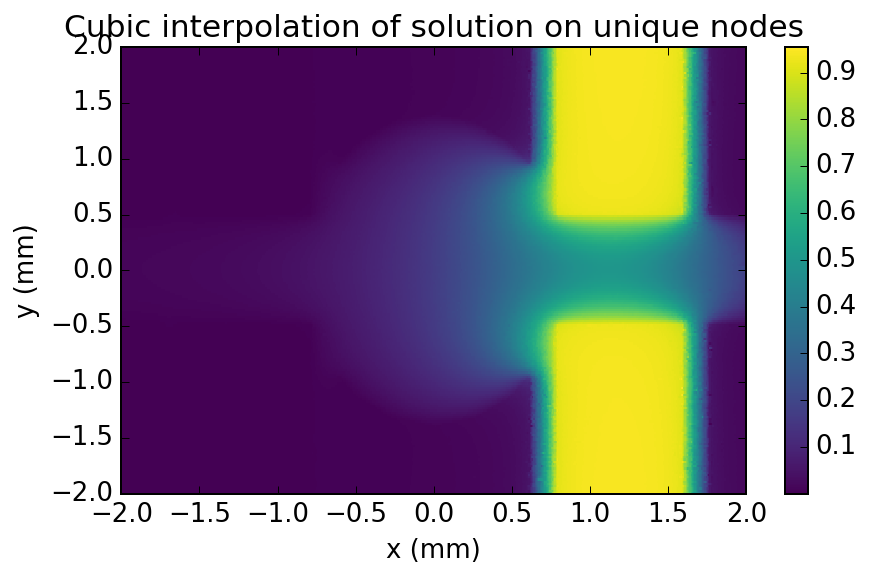

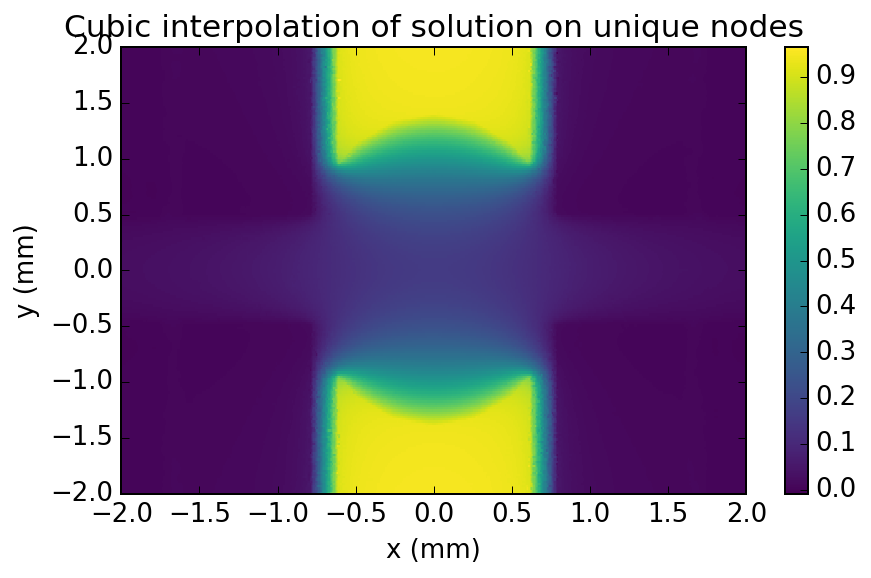

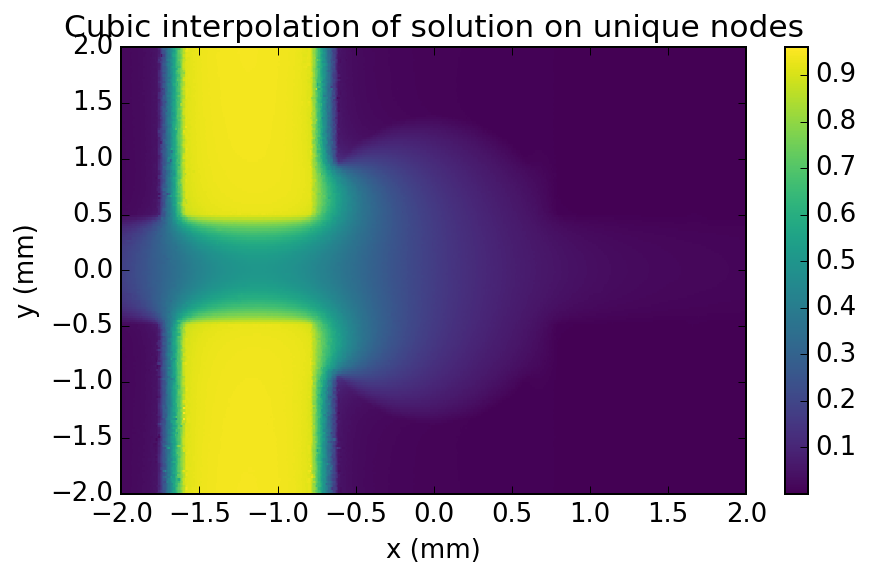

In [2]:
# Evaluate all files in the range
xeval=np.linspace(-2, 2, 501)
yeval = np.linspace(-2, 2, 201)


datafiles = ["data/simulation/Maxwell/160528 - Trap area - fine mesh/0000 160528 - M016v5 trap xy (resonator) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0001 160528 - M016v5 trap xy (trap) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0002 160528 - M016v5 trap xyz (guardres) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0003 160528 - M016v5 trap xyz (guardcenter) fine mesh.dsp", 
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0004 160528 - M016v5 trap xyz (guardtrap) fine mesh.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(7.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join('/mnt/s/_Data/160513 - EonHe M016v5', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})

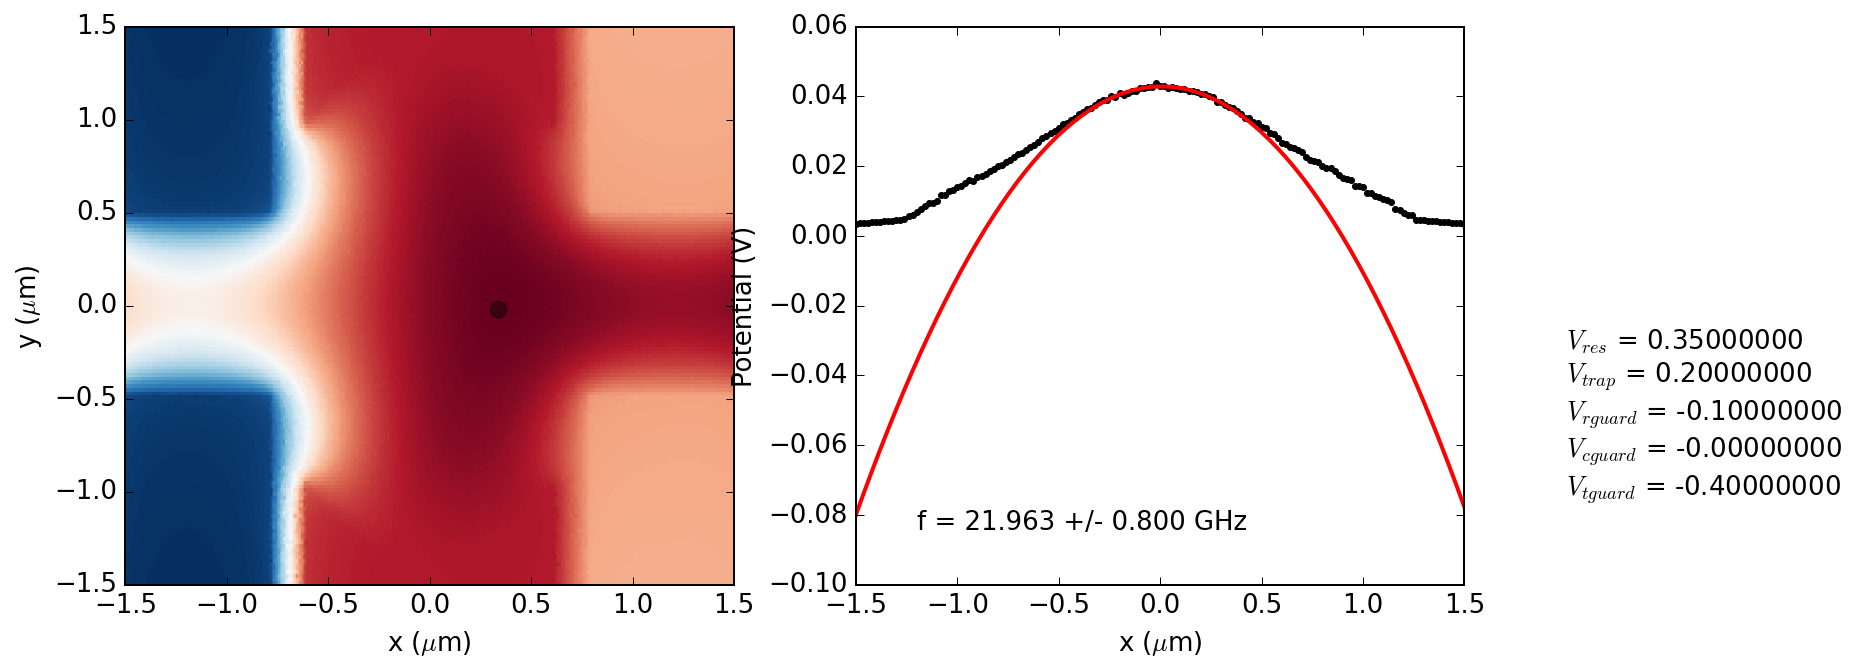

In [6]:
%matplotlib inline
t = trap_analysis.TrapSolver()

x, y, cropped_potentials = t.crop_potentials(output, xdomain=(-1.5,1.5), ydomain=(-1.5, 1.5))
import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,5.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+2.25, trap=+1.20, resonatorguard=-3.0, centerguard=-0.0, trapguard=-3.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, 
                            resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
                            auto_scale=True):
    
    fig = plt.figure()
    plt1 = fig.add_subplot(1,2,1)
    plt2 = fig.add_subplot(1,2,2)
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    #plt.pcolormesh(x*1E6, y*1E6, combined_potential, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
    #plt1.imshow(combined_potential, extent=[min(x)*1E6, max(x)*1E6, min(y)*1E6, max(y)*1E6], cmap=plt.cm.RdBu_r,
    #           aspect='auto', interpolation='none')
    if not auto_scale:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
    if fit_potential_minimum:
        yidx,xidx = np.where(combined_potential==np.max(combined_potential))
    else: 
        yidx = np.array([common.find_nearest(y, 0.0)])
        xidx = np.array([common.find_nearest(x, 0.0)])
    plt1.plot(x[xidx], y[yidx], 'o', **common.plot_opt("black"))
    
    #print yidx, xidx
    #print np.shape(yidx), np.shape(xidx)
    
    #cb.outline.set_visible(False)
    #cb.ax.set_ylabel("Voltage (V)")
    
    plt1.set_xlabel("x ($\mu$m)")
    plt1.set_ylabel("y ($\mu$m)")
    
    Vdata = combined_potential[:,xidx[0]]
    xdata = y
    plt2.plot(xdata, Vdata, '.k')
    
    try:
        fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
        plt2.plot(xdata, kfit.parabolafunc(xdata, *fr), '-r', lw=2.0)
        f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    except:
        f0, sigmaf0 = 0, 0
    
    plt2.set_xlabel("x ($\mu$m)")
    plt2.set_ylabel("Potential (V)")
    #plt2.set_ylim(-1, 1)
    plt2.set_xlim(min(xdata), max(xdata))
    plt.gca().set_axis_bgcolor('none')
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt2.text(xmin + 0.1*(xmax-xmin), ymin + 0.1*(ymax-ymin), "f = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))
    
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{cguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, centerguard * 10**scaling, trapguard * 10**scaling)
    
    plt2.text(2, ymin + 0.1*(ymax-ymin), biasVoltages)
    plt.show()
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05),
         resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
         auto_scale=True);